In [46]:
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
matplotlib.rcParams.update({'font.size':16})

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import votable
from astropy.utils import data
data.conf.remote_timeout = 60 # default is 3 seconds

In [47]:
url_templ = 'http://gsss.stsci.edu/webservices/vo/CatalogSearch.aspx?CAT=PS1V3OBJECTS&RA={ra}&DEC={dec}&SR={rad}'

def get_votable(ra=0,dec=0,radius=5/60,name=''):
    # ra, dec, radius must be in degrees
    if name != '':
        gal = SkyCoord.from_name(name)
        ra = gal.ra.deg
        dec = gal.dec.deg
    url = url_templ.format(ra=ra,dec=dec,rad=radius)
    tab = votable.parse_single_table(url).to_table()
    return tab

def fit_isochrone(table,isochrone,distance=1000*np.linspace(10,500,100),col=('g','i'),mag='r'):
    # default distance array is 10 to 500 kpc
    distmod = 5*np.log10(distance/10)
    numclosestars = np.zeros(distance.size)
    for j in range(distance.size):
        for i in range(table[mag+'MeanPSFMag'].size):
            point = np.array([table[col[0]+'MeanPSFMag'][i]-table[col[1]+'MeanPSFMag'][i],
                              table[mag+'MeanPSFMag'][i]]).reshape(-1,1)
            iso = np.array([isochrone[col[0]]-isochrone[col[1]],isochrone[mag]+distmod[j]])
            if np.any( (np.abs(point[1]-iso[1]) < table[mag+'MeanPSFMagStd'][i])*(np.abs(point[0]-iso[0]) \
                            < np.sqrt(table[col[0]+'MeanPSFMagStd'][i]**2+table[col[1]+'MeanPSFMagStd'][i]**2)) ):
                numclosestars[j] += 1
    return distance, numclosestars


In [48]:
# load isochrone data
isoc1 = Table.read('t=12Gyr_Fe=-1.0.dat',format='ascii')
isoc1 = Table(isoc1,names=('metallicity','logage','M_ini','M_act','logL/Lo','logTe','logG','mbol',
                           'g','r','i','z','y','w','int_IMF','stage'))
isoc15 = Table.read('t=12Gyr_Fe=-1.5.dat',format='ascii')
isoc15 = Table(isoc15,names=('metallicity','logage','M_ini','M_act','logL/Lo','logTe','logG','mbol',
                             'g','r','i','z','y','w','int_IMF','stage'))
isoc2 = Table.read('t=12Gyr_Fe=-2.0.dat',format='ascii')
isoc2 = Table(isoc2,names=('metallicity','logage','M_ini','M_act','logL/Lo','logTe','logG','mbol',
                           'g','r','i','z','y','w','int_IMF','stage'))

# define RGB (3) and AGB (7) and HB (4) stars in isochrone
isoc1 = isoc1[(isoc1['stage']==3)+(isoc1['stage']==7)+(isoc1['stage']==4)]
isoc15 = isoc15[(isoc15['stage']==3)+(isoc15['stage']==7)+(isoc15['stage']==4)]
isoc2 = isoc2[(isoc2['stage']==3)+(isoc2['stage']==7)+(isoc2['stage']==4)]

# isochrone plot
#f = pl.figure(figsize=(6,6))
#pl.scatter(isoc1['g']-isoc1['i'],isoc1['r'],
#           alpha=0.5,s=20,label=r'$[\rm{Fe/H}] = -1.0$')
#pl.scatter(isoc15['g']-isoc15['i'],isoc15['r'],
#           alpha=0.5,s=20,label=r'$[\rm{Fe/H}] = -1.5$')
#pl.scatter(isoc2['g']-isoc2['i'],isoc2['r'],
#           alpha=0.5,s=20,label=r'$[\rm{Fe/H}] = -2.0$')
#pl.xlim(-0.5,2)
#pl.gca().invert_yaxis()
#pl.xlabel(r'$g-i$')
#pl.ylabel(r'$r$')
#pl.legend(loc='lower left')

Draco_dSph ...


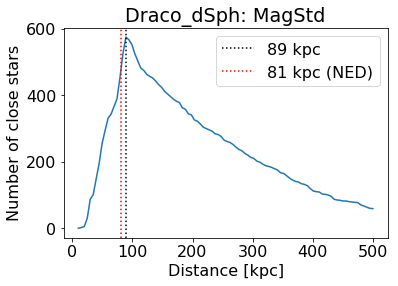

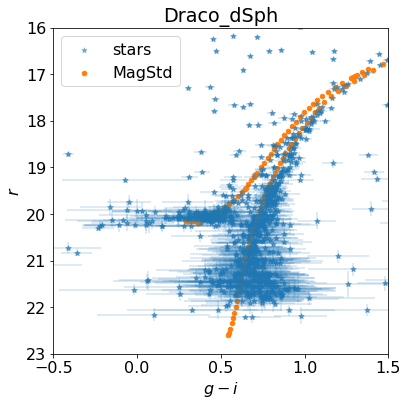

In [55]:
gals = ['Bootes_dSph','Bootes_II','Canes_Venatici_dSph',
        'Coma_Berenices','Draco_dSph','Hercules_dSph',
        'Leo_IV','Leo_V','Leo_T','Segue_1',
        'Ursa_Major_dSph','Ursa_Major_II','Willman_1_dSph']

gals = ['Draco_dSph']

for gal in gals:
    print(gal,'...')
    # get votable for desired object
    tab = get_votable(name=gal)

    # separate stars from non-stars 
    # (see https://confluence.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies)
    star_tab = tab[tab['iMeanPSFMag']-tab['iMeanKronMag'] < 0.05]

    # only use starswith defined magnitudes and magstds (!= -999) 
    star_tab = star_tab[(star_tab['gMeanPSFMag'] != -999)*\
                        (star_tab['iMeanPSFMag'] != -999)*(star_tab['rMeanPSFMag'] != -999)]
    star_tab = star_tab[(star_tab['gMeanPSFMagStd'] != -999)*\
                        (star_tab['iMeanPSFMagStd'] != -999)*(star_tab['rMeanPSFMagStd'] != -999)]

    # perform isochrone fit (choose one to use)
    distance, numclosestars = fit_isochrone(star_tab,isoc15)

    # plot fit results
    f = pl.figure()
    pl.plot(distance/1000,numclosestars,label='')
    pl.xlabel('Distance [kpc]')
    pl.ylabel('Number of close stars')
    bestdist = distance[numclosestars==numclosestars.max()][0]
    pl.axvline(x=bestdist/1000,linestyle='dotted',color='black',label=str(np.int(bestdist/1000))+' kpc')
    pl.axvline(x=81,linestyle='dotted',color='red',label='81 kpc (NED)')
    pl.title(gal+': MagStd')
    pl.legend()
    pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
    pl.savefig('plots/CMDs/'+gal+'_fitresult.pdf')

    # Plot CMD with best-fit isochrone
    f = pl.figure(figsize=(6,6))
    pl.scatter(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
               s=25,alpha=0.5,marker='*',label='stars')
    pl.errorbar(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
                xerr=np.sqrt(star_tab['gMeanPSFMagStd']**2+star_tab['iMeanPSFMagStd']**2),
                yerr=star_tab['rMeanPSFMagStd'],alpha=0.2,fmt='*',label='')
    pl.xlim(-0.5,1.5)
    pl.ylim(16,23)
    pl.xlabel(r'$g-i$')
    pl.ylabel(r'$r$')
    pl.gca().invert_yaxis()
    pl.scatter(isoc15['g']-isoc15['i'],isoc15['r']+5*np.log10(bestdist/10),
               s=20,alpha=1,label='MagStd',marker='o')
    pl.legend()
    pl.title(gal)
    pl.savefig('plots/CMDs/'+gal+'_CMD.pdf')

In [83]:
## Older version of the stuff above, before I put things into functions ##

# define distance moduli
distance = 1000*np.linspace(10,500,100) # 10 to 500 kpc
distmod = 5*np.log10(distance/10)

# Find best-fit isochrone, once using MagStd, once using MagErr
numclosestars = np.zeros(distance.size)
for j in range(distance.size):
    for i in range(star_tab['rMeanPSFMag'].size):
        point = np.array([star_tab['gMeanPSFMag'][i]-star_tab['iMeanPSFMag'][i],
                          star_tab['rMeanPSFMag'][i]]).reshape(-1,1)
        iso = np.array([isoc15['g']-isoc15['i'],isoc15['r']+distmod[j]])
        if np.any( (np.abs(point[1]-iso[1]) < star_tab['rMeanPSFMagStd'][i])*(np.abs(point[0]-iso[0]) \
                        < np.sqrt(star_tab['gMeanPSFMagStd'][i]**2+star_tab['iMeanPSFMagStd'][i]**2)) ):
            numclosestars[j] += 1
            
numclosestars1 = np.zeros(distance.size)
for j in range(distance.size):
    for i in range(star_tab['rMeanPSFMag'].size):
        point = np.array([star_tab['gMeanPSFMag'][i]-star_tab['iMeanPSFMag'][i],
                          star_tab['rMeanPSFMag'][i]]).reshape(-1,1)
        iso = np.array([isoc15['g']-isoc15['i'],isoc15['r']+distmod[j]])
        if np.any( (np.abs(point[1]-iso[1]) < star_tab['rMeanPSFMagErr'][i])*(np.abs(point[0]-iso[0]) \
                        < np.sqrt(star_tab['gMeanPSFMagErr'][i]**2+star_tab['iMeanPSFMagErr'][i]**2)) ):
            numclosestars1[j] += 1

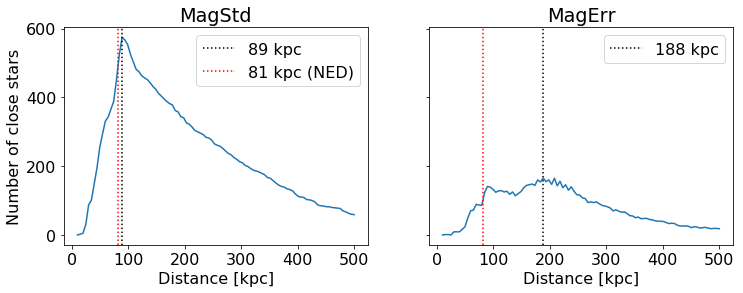

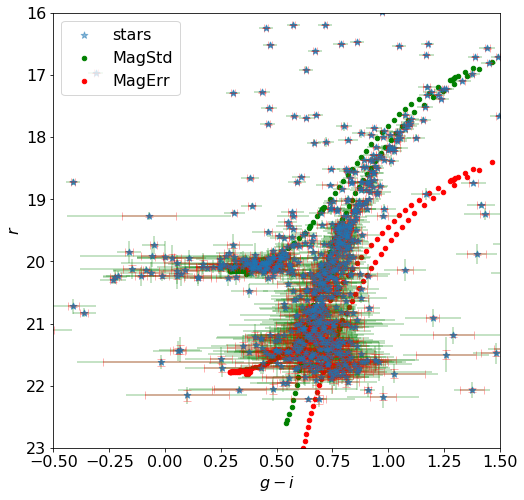

In [84]:
## Detailed plots comparing MagStd and MagErr ##

# Plot results of fit            
f, (ax1, ax2) = pl.subplots(1,2,sharex=True,sharey=True,figsize=(12,4))            
ax1.plot(distance/1000,numclosestars,label='')
ax1.set_xlabel('Distance [kpc]')
ax1.set_ylabel('Number of close stars')
bestdist = distance[numclosestars==numclosestars.max()][0]
ax1.axvline(x=bestdist/1000,linestyle='dotted',color='black',label=str(np.int(bestdist/1000))+' kpc')
ax1.axvline(x=81,linestyle='dotted',color='red',label='81 kpc (NED)')
ax1.set_title('MagStd')
ax1.legend()
ax2.plot(distance/1000,numclosestars1,label='')
ax2.set_xlabel('Distance [kpc]')
bestdist1 = distance[numclosestars1==numclosestars1.max()][0]
ax2.axvline(x=bestdist1/1000,linestyle='dotted',color='black',label=str(np.int(bestdist1/1000))+' kpc')
ax2.axvline(x=81,linestyle='dotted',color='red',label='')
ax2.set_title('MagErr')
ax2.legend()

# Galaxy CMD with best-fit isochrones
f = pl.figure(figsize=(8,8))
pl.scatter(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
           s=50,alpha=0.5,marker='*',label='stars')
pl.errorbar(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
            xerr=np.sqrt(star_tab['gMeanPSFMagStd']**2+star_tab['iMeanPSFMagStd'][i]**2),
            yerr=star_tab['rMeanPSFMagStd'],alpha=0.3,fmt='*',ecolor='green',label='')
pl.errorbar(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
            xerr=np.sqrt(star_tab['gMeanPSFMagErr']**2+star_tab['iMeanPSFMagErr'][i]**2),
            yerr=star_tab['rMeanPSFMagErr'],alpha=0.3,fmt='*',ecolor='red',capsize=4,label='')
pl.xlim(-0.5,1.5)
pl.ylim(16,23)
pl.xlabel(r'$g-i$')
pl.ylabel(r'$r$')
pl.gca().invert_yaxis()
pl.scatter(isoc15['g']-isoc15['i'],isoc15['r']+5*np.log10(bestdist/10),
           s=20,alpha=1,label='MagStd',marker='o',color='green')
pl.scatter(isoc15['g']-isoc15['i'],isoc15['r']+5*np.log10(bestdist1/10),
           s=20,alpha=1,label='MagErr',marker='o',color='red')
pl.legend(loc='upper left')

In [ ]:
# as a next step, try doing a bunch of these in a row for various known galaxies, see how accurate distances are
# and how good isochrones look on CMD. 